In [1]:
import bertopic
import re
import jieba
import pandas as pd
import os

### 改变工作路径

In [2]:
os.getcwd()
os.chdir('e:\\code\\python_code\\BDManager\\sunshaolong\\hoteldata')

### 读入文本数据
* 这里在数据预处理部分：令123分标签为-1，45标签为1进行处理
  * 队友酒店评论1-5的评分，如果顾客给了3分相对中立的评价，那么说明顾客的体验可能并不是那么好，于是我们将标签划分为负类。
* 同时加入了标题项。因为顾客评论的标题是顾客情感倾向表达最为明显的部分，将标题与评论进行拼接，进行分词。可以增大情感的倾向性。提高模型主题挖掘的准确性

In [3]:

data = pd.read_csv('评论与评分.csv',index_col=0)
data.head()

,title,review,rating,label
0,积分兑换的超值房,酒店离西安火车站一街之隔，但算是闹中取静；服务员非常热情，对待客人礼貌有加；房间内卫生良好，...,4,1
1,离车站近,住的那间房价格是里面比较便宜的，窗子真的挺小，好在还是有窗户的，没窗户的肯定会更难受。大床房...,3,-1
2,离火车站挺近,位置还不错，在钟楼和火车站中间，走路去火车站十分钟。在一个巷子里面，在北新街上有招牌指引进去...,5,1
3,离火车站很近,最大的好处就是离火车站很近，前往秦始皇兵马俑、华山的公交车都在火车站广场发车，住在该酒店出发...,4,1
4,第一次住7天 服务和价格都非常不错 房间很小但是足够睡一觉,就在火车站附近 附近也有机场大巴 位置不错\r\n酒店边上环境稍差 比较脏乱差\r\n第一次...,5,1


### 中文文本预处理
* jieba分词，词性分析，短词舍弃

**这是测试部分，正式分词的函数是下面的**

```python
# 构造一个清洗文本的函数，构造成像英文文本一样的分词格式
# import jieba.analyse as analyse
# mlessdic=['酒店','西安','他们','我们','这里','今天','这次','这家','的','是']
def clean_text(text):
    try:
        text=re.sub("[a-zA-Z]",'',text)
        cutor=jieba.lcut(text)
        # cutor=re.sub('[酒店|西安|他们|我们|]','',''.join(cutor))
    except:
        return ''
    # 空格分词
    return ' '.join([i for i in cutor if len(i)>1 ])
# # test
# a="酒店离西安火车站一街之隔，但算是闹中取静；服务员非常热情，对待客人礼貌有加；房间内卫生良好，隔音情况良好；免费的无线网络连接比较顺畅。"
# a='开会。来香格里拉开会 遇到了宾客关系小姐姐Abby 和Nancy 服务态度很好 很热情 很nice 酒店很满意 不论是服务还是设施都称得上完美 下次还会再来'
a='入住体验很好。西安丽思卡尔顿酒店整体很好很舒服，服务也很及时。客房服务张亚琴、徐佳新服务态度很好，很及时，好评点赞，值得推荐入住。'
clean_text(a)
# jieba.lcut(a)
import jieba.posseg as pseg
words= pseg.lcut(a)
# # analyse.extract_tags(words, topK=20, withWeight=True, allowPOS=([]))
# # words
' '.join([i for i,f in words if len(i)>=2 and (f=='n' or f.startswith('v') or f.startswith('a') or f.startswith('l'))])
# for i,tag in words:
#     print(i,tag)
```

### clean_text_lavn():
* l:成语
* a:形容词系
  * a：普通形容词
  * ad：副形词
  * an：名形词
* v：动词词系，包括
  * v:普通动词
  * vd：动副词
  * vn：动名词
* n：普通名词（剔除nr人名、ns地名、nt机构名、nw作品名、nz其他专有名词）

In [4]:
from jieba import posseg as pseg
def clean_text_lavn(text):
    '''
    jieba分词词性选择：
    名词（不要人名）
    动词类
    形容词类
    成语（如果有的话）
    '''

    words= pseg.lcut(text)
    return ' '.join([i for i,f in words if len(i)>=2 and (f=='n' or f.startswith('v') or f.startswith('a') or f.startswith('l'))])
# test
a='中国最好的酒店。我们在中国旅行的时候在陕西奥罗国际大酒店住了15天。我们觉得酒店的服务和房间都很棒。房间很干净(干爽的白床单),家具和设施都是全新的。自助早餐很棒,有许多冷热食物(西餐和亚洲菜)还有现作的煎蛋卷和许多新鲜水果。客户服务很棒,每个员工英语说的都很棒。很推荐,会再去住的。'
clean_text_lavn(a)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\zhangjy\AppData\Local\Temp\jieba.cache
Loading model cost 0.782 seconds.
Prefix dict has been built successfully.


'最好 酒店 旅行 时候 国际 大酒店 觉得 酒店 服务 房间 很棒 房间 干净 干爽 床单 家具 设施 自助 早餐 很棒 冷热 食物 西餐 还有 现作 煎蛋卷 水果 客户服务 很棒 员工 很棒 推荐'

### 连接标题与文本

In [5]:
data['text']=data['title'].str.cat(data['review'],sep='。')

In [6]:
data['text'].info()

<class 'pandas.core.series.Series'>
Int64Index: 43178 entries, 0 to 43177
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
43172 non-null  object
dtypes: object(1)
memory usage: 674.7+ KB


In [8]:
# data['content']=1
data['content']=data['text'].astype(str).apply(clean_text_lavn)

### 去除空值    

In [9]:
data.dropna(inplace=True)
data.shape

(43172, 6)

In [11]:
data.to_csv('酒店评论_语料.csv')

In [132]:
data['content'].to_list()


0        积分 兑换 超值 酒店 火车站 算是 闹中取静 服务员 热情 对待 客人 礼貌 有加 房间内...
1        车站 房价格 便宜 窗子 窗户 窗户 肯定 难受 床房 被子 有点 空调 有点 好像 不怎么...
2                  火车站 位置 不错 火车站 走路 火车站 巷子 招牌 指引 进去 好找 服务员
3           火车站 最大 火车站 兵马俑 公交车 火车站 广场 发车 酒店 出发 方便 设施 不错 早餐
4        服务 价格 不错 房间 很小 足够 火车站 机场 大巴 位置 不错 酒店 环境 稍差 脏乱差...
                               ...                        
43173    很漂亮 区域 很棒 位置 回到 酒店 酒店 区域 很漂亮 酒店 对面 公园 走路 地方 商店...
43174    位置 很棒 酒店 位置 人民广场 员工 热心 入住 时候 双人间 升级 套房 房间 很小 套...
43175    最好 酒店 旅行 时候 国际 大酒店 觉得 酒店 服务 房间 很棒 房间 干净 干爽 床单 ...
43176                 位置 酒店 装潢 一般 酒店 位置 车站 兵马俑 方便 酒店 装潢 一般
43177    地理位置 不错 感觉 早餐 早餐 西餐 用餐 形式 没有 限制 自助 早餐 标准 好像 吃饭...
Name: content, Length: 43172, dtype: object

## 词云

In [13]:
data['content'].to_list()

['积分 兑换 超值 酒店 火车站 算是 闹中取静 服务员 热情 对待 客人 礼貌 有加 房间内 卫生 良好 隔音 情况 良好 免费 无线网络 连接 顺畅',
 '车站 房价格 便宜 窗子 窗户 窗户 肯定 难受 床房 被子 有点 空调 有点 好像 不怎么 管用 空调 感觉 不到 出来 挺好 车站 极大 方便 赶车 人们',
 '火车站 位置 不错 火车站 走路 火车站 巷子 招牌 指引 进去 好找 服务员',
 '火车站 最大 火车站 兵马俑 公交车 火车站 广场 发车 酒店 出发 方便 设施 不错 早餐',
 '服务 价格 不错 房间 很小 足够 火车站 机场 大巴 位置 不错 酒店 环境 稍差 脏乱差 服务 价格 不错 房间 很小 足够 房间 有点 整体 印象',
 '火车站 火车站 环境 噪音控制 有点 挨着 火车站 有点 噪音 接受 性价比 交通 方便 卫生 考虑 入住 酒店',
 '价格便宜 牛奶 价格 比如 便宜 服务 会员 牛奶 酒店 位置 火车站 交通 方便 乘车 方便 十字路口 没有 方便 商场 距离 火车站 房间 颜色 没有 白色 没有 绿色 感觉 房间 采光 差不多 可能 火车站 偏近 还好 早餐 提供 收费 卫生 专人 打扫 设施',
 '卫生 不错 服务 相对来说 服务 还有 环境 不错 经济型 酒店 肯定 不到 满意 酒店 位置 火车站 估计 酒店 火车站 交通 方便 酒店 服务 不错 态度 房间 卫生 方面 不错 牙刷 时候 带走 相当于 送给 硬件 设施 提供 网线 空间 酒店 提供 免费 早餐 口味 面食 高点 炒饭',
 '酒店 配套 设施 不太好 火车站 走路 需要 房间 制暖 不够 酒店 配套 设施 不太好 质量 酒店 质量 中央空调 制热 效果 结果 没有 解决 制热 结果 冻死 繁华 地段 主干道',
 '模式 总体 感觉 模式 预订 推出 还有 推广 硬件 设施 快捷酒店 差不多 快捷酒店 干净 房间 很大 感觉 快捷酒店 装修 差不多 不会 火车站 隔音 效果 房间 面积 很大 采光 通风 服务员 帮助 预定 好像 有点 协助 预定',
 '安全 干静 卫生 整体 环境 环境 干净 卫生 服务 交通 方面 打车 费劲 需要 打到 房间 房间 设施 房间 网线 电脑 房间 没有 网速 一般 刮胡刀 刮胡刀 收费 洗漱 

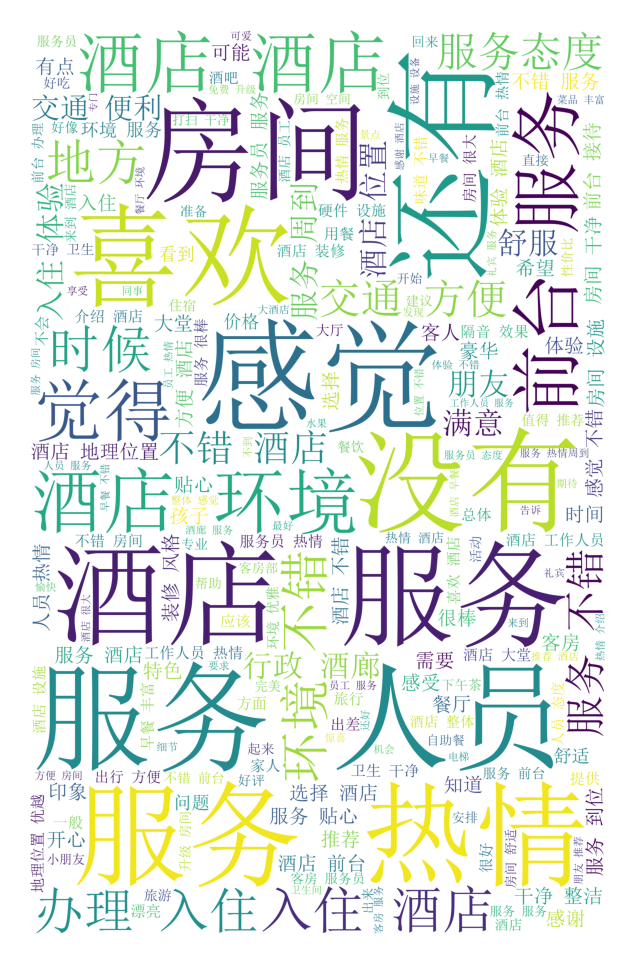

In [16]:
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image #处理图片
import matplotlib.pyplot as plt
wc=WordCloud(width=1400, height=2200,
			background_color='white',
	        mode='RGB', 
            font_path=r"c:\windows\fonts\simsun.ttc",
			max_font_size=300,
			relative_scaling=0.1, #设置字体大小与词频的关联程度为0.4
			random_state=50, 
			scale=2 ).generate(''.join(data['content'].to_list()))


plt.figure(dpi=300)
plt.imshow(wc) #显示词云
plt.axis('off') #关闭x,y轴
plt.show()#显示
wc.to_file('test1_ciyun.jpg') #保存词云图

### Bertopic模型训练

In [133]:
topic_model = bertopic.BERTopic(language="chinese (simplified)",
                                calculate_probabilities=True,
                                verbose=True,
                                # nr_topics='auto'
                                )
# 好评分类
topics1, probs = topic_model.fit_transform(data['content'].to_list())


Batches: 100%|██████████| 1350/1350 [22:14<00:00,  1.01it/s]
2022-12-10 12:45:40,725 - BERTopic - Transformed documents to Embeddings
2022-12-10 12:46:14,784 - BERTopic - Reduced dimensionality
2022-12-10 12:53:44,460 - BERTopic - Clustered reduced embeddings


### 模型保存

In [17]:
os.chdir("E:\code\python_code\BDManager\sunshaolong\model")
topic_model.save('中文分词模型2_选择vnal词+标题')


NameError: name 'topic_model' is not defined

### 模型加载


In [18]:
os.chdir("E:\code\python_code\BDManager\sunshaolong\model")

topic_model=bertopic.BERTopic.load('中文分词模型2_选择vnal词+标题')

In [6]:
topic_model.visualize_barchart()

In [19]:
# 保存主题分布图
import plotly

fig=topic_model.visualize_topics()
# fig.write_image('model2_vnal分词主题图.pdf',scale=2)
fig

In [138]:
# 保存主题细节
topic_model.get_topic_info().to_csv('E:\code\python_code\BDManager\sunshaolong\hoteldata\话题_vnal分词.csv')

### 训练集与测试集
* X为向量化的文本
* y为标签

In [152]:
X=pd.DataFrame(probs,columns=topic_model.get_topic_info()['Name'][1:],index=data.index)
y=data.label

In [20]:
# 或者从已经保存到本地的数据中加载
data=pd.read_csv(r'E:\code\python_code\BDManager\sunshaolong\model\topic2vec数据.csv',index_col=0)
X=data.iloc[:,:-1]
y=data.iloc[:,-1]

In [8]:
X.shape[0],y.shape[0]

(43172, 43172)

In [156]:
os.getcwd()

'E:\\code\\python_code\\BDManager\\sunshaolong\\model'

In [157]:
# 保存一步数据
pd.concat([X,y],axis=1).to_csv('topic2vec数据.csv')

In [162]:
X.head()


Name,0_游泳_泳池_健身_健身房,1_感谢_帮助_礼宾_感谢信,2_会议_宴会厅_表扬信_配合,3_西餐厅_菜品_全味_西餐,4_水疗_理疗_手法_护理,5_中餐厅_菜品_用餐_味道,6_酒廊_行政_欢乐_时光,7_下午茶_鸡尾酒_拍照_甜点,8_孩子_小朋友_客房部_喜欢,9_婚宴_婚礼_宴会厅_富贵,...,273_倾国倾城_关系_主管_不伤,274_员会_朝气_走入_因公,275_下午茶_薰衣草_双人_甜品,276_品牌_品牌形象_旗下_诚意,277_重用_款式_提现_素质,278_火锅店_火锅_吃回本_券比,279_回来_稀罕_十分满意_哦哦哦,280_女朋友_完爆_还定_年轻人,281_广场_历史_炫耀_艺术,282_说走就走_苦于_支走_同房
0,0.001172,0.002195,0.001417,0.001055,0.000780,0.000933,0.001707,0.001173,0.002346,0.001051,...,0.002176,0.003310,0.001194,0.003751,0.001209,0.001072,0.002969,0.002689,0.007281,0.003843
1,0.001094,0.001397,0.001081,0.000983,0.000799,0.000927,0.001465,0.001077,0.001617,0.000882,...,0.001606,0.001888,0.001102,0.002296,0.001152,0.001025,0.001706,0.001608,0.002933,0.001956
2,0.001069,0.001712,0.001243,0.001015,0.000767,0.000948,0.001536,0.001127,0.001949,0.000958,...,0.001949,0.002330,0.001153,0.002670,0.001202,0.001062,0.002131,0.002073,0.004018,0.002635
3,0.001082,0.001752,0.001276,0.001033,0.000777,0.000968,0.001557,0.001147,0.001989,0.000982,...,0.001995,0.002373,0.001174,0.002690,0.001225,0.001083,0.002176,0.002114,0.004084,0.002677
4,0.001223,0.002070,0.001506,0.001080,0.000814,0.001030,0.001675,0.001215,0.002284,0.001150,...,0.002362,0.002549,0.001247,0.002530,0.001311,0.001160,0.002483,0.002150,0.003511,0.002489


### 查看数据的平衡性，发现标签存在极度不平衡的现象，未来的机器学习模型训练时要进行处理。
* 一些常见的处理样本不平衡的方法：SMOTE等

## 样本不平衡的问题
``
pip install imblearn``

In [164]:
# 看一下标签数据的平衡性
y.value_counts()

 1    41523
-1     1649
Name: label, dtype: int64

In [21]:
#划分训练集和测试集 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    random_state=0,
                                                    test_size=0.2)

In [172]:
X_train

Name,0_游泳_泳池_健身_健身房,1_感谢_帮助_礼宾_感谢信,2_会议_宴会厅_表扬信_配合,3_西餐厅_菜品_全味_西餐,4_水疗_理疗_手法_护理,5_中餐厅_菜品_用餐_味道,6_酒廊_行政_欢乐_时光,7_下午茶_鸡尾酒_拍照_甜点,8_孩子_小朋友_客房部_喜欢,9_婚宴_婚礼_宴会厅_富贵,...,273_倾国倾城_关系_主管_不伤,274_员会_朝气_走入_因公,275_下午茶_薰衣草_双人_甜品,276_品牌_品牌形象_旗下_诚意,277_重用_款式_提现_素质,278_火锅店_火锅_吃回本_券比,279_回来_稀罕_十分满意_哦哦哦,280_女朋友_完爆_还定_年轻人,281_广场_历史_炫耀_艺术,282_说走就走_苦于_支走_同房
7345,1.134184e-03,2.099279e-03,1.925625e-03,2.455424e-03,1.451205e-03,2.465772e-03,3.197050e-03,2.051111e-02,1.717280e-03,1.992454e-03,...,2.428853e-03,1.815048e-03,1.345100e-02,1.986418e-03,4.057090e-03,3.108213e-03,1.584113e-03,2.419274e-03,1.335488e-03,2.097278e-03
18668,2.474387e-307,7.008334e-307,3.406403e-307,1.875869e-307,1.435397e-307,1.614924e-307,3.356056e-307,2.123484e-307,5.275021e-307,2.349630e-307,...,4.743665e-307,9.996120e-307,2.153027e-307,5.854194e-307,2.129545e-307,1.899844e-307,1.328123e-306,5.371919e-307,7.668802e-307,6.200432e-307
37865,9.526015e-04,3.057167e-03,1.230476e-03,7.119486e-04,5.258882e-04,5.942818e-04,1.205058e-03,7.999593e-04,2.172589e-03,8.589109e-04,...,1.644351e-03,4.607773e-03,8.060396e-04,1.936524e-03,7.818728e-04,6.991428e-04,6.371505e-03,2.656679e-03,2.911235e-03,3.217894e-03
21758,2.598062e-307,6.198035e-307,3.090033e-307,1.814438e-307,1.491464e-307,1.568563e-307,3.028380e-307,2.037967e-307,4.949835e-307,2.186443e-307,...,4.083482e-307,8.657321e-307,2.054423e-307,5.094683e-307,2.011536e-307,1.808204e-307,1.111563e-306,5.332986e-307,1.140866e-306,6.660534e-307
14792,8.953928e-04,3.923736e-03,1.478986e-03,7.089662e-04,5.007741e-04,6.086020e-04,1.285601e-03,8.276086e-04,2.355451e-03,9.841710e-04,...,1.893221e-03,5.611910e-03,8.351875e-04,1.955630e-03,8.087193e-04,7.192458e-04,1.530020e-02,2.519079e-03,2.532945e-03,2.793885e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32109,1.256175e-03,4.446665e-03,1.984937e-03,1.066426e-03,8.623571e-04,9.138252e-04,2.079745e-03,1.318910e-03,3.143103e-03,1.360991e-03,...,2.764536e-03,1.057587e-02,1.318935e-03,2.851071e-03,1.225077e-03,1.070426e-03,6.418031e-03,5.576877e-03,4.063724e-03,9.028825e-03
30409,6.975397e-04,1.651317e-03,1.163706e-03,7.427185e-04,5.046357e-04,7.012389e-04,1.399482e-03,8.896556e-04,1.643340e-03,8.467661e-04,...,2.050040e-03,2.276144e-03,9.164117e-04,2.515747e-03,9.492668e-04,8.194753e-04,1.917098e-03,1.729297e-03,2.340522e-03,2.083053e-03
21248,1.161728e-03,4.848092e-03,2.314223e-03,1.190006e-03,9.420567e-04,1.010690e-03,2.802592e-03,1.554031e-03,2.816396e-03,1.554168e-03,...,3.295525e-03,8.499061e-03,1.556484e-03,3.362944e-03,1.397733e-03,1.208415e-03,5.112991e-03,6.900906e-03,3.254791e-03,9.654043e-03
42619,8.116890e-04,1.743736e-03,1.242588e-03,9.549706e-04,5.516180e-04,8.819712e-04,1.691069e-03,1.124878e-03,2.087408e-03,9.627938e-04,...,2.299710e-03,2.413632e-03,1.169386e-03,3.054250e-03,1.254152e-03,1.054718e-03,1.979220e-03,2.094448e-03,2.260807e-03,2.503757e-03


In [186]:
y_train.shape
X_train.shape
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43172 entries, 0 to 43177
Columns: 283 entries, 0_游泳_泳池_健身_健身房 to 282_说走就走_苦于_支走_同房
dtypes: float64(283)
memory usage: 94.6 MB


In [22]:
from imblearn.over_sampling import BorderlineSMOTE
smo=BorderlineSMOTE(random_state=0)
print('采样前：',X.shape[0])
print(y_train.value_counts())
X__train,y__train = smo.fit_resample(X_train,y_train)
print('采样后：',data.shape[0])
print(y__train.value_counts())

采样前： 43172
 1    33215
-1     1322
Name: label, dtype: int64
采样后： 43172
 1    33215
-1    33215
Name: label, dtype: int64


**样本已经达到平衡了！**

In [23]:
from sklearn.svm import SVC
# baseline svm
svm=SVC(probability=True)
svm.fit(X__train,y__train)
print(svm.score(X_test,y_test))
# print(svm.coef_)

0.8546612623045744


AttributeError: coef_ is only available when using a linear kernel

In [41]:
svm.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [42]:
# print(svm._get_coef())
featuredf=pd.DataFrame({'topic':X.columns,'importance':svm._get_coef().ravel()})
# topic_model.get_topic(281)
featuredf.sort_values(axis=0,key=abs,by='importance',ascending=False).to_csv('svm系数权重.csv')



In [43]:
os.getcwd()

'E:\\code\\python_code\\BDManager\\sunshaolong\\model'

In [22]:
y_test.value_counts()

 1    8308
-1     327
Name: label, dtype: int64

<AxesSubplot: >

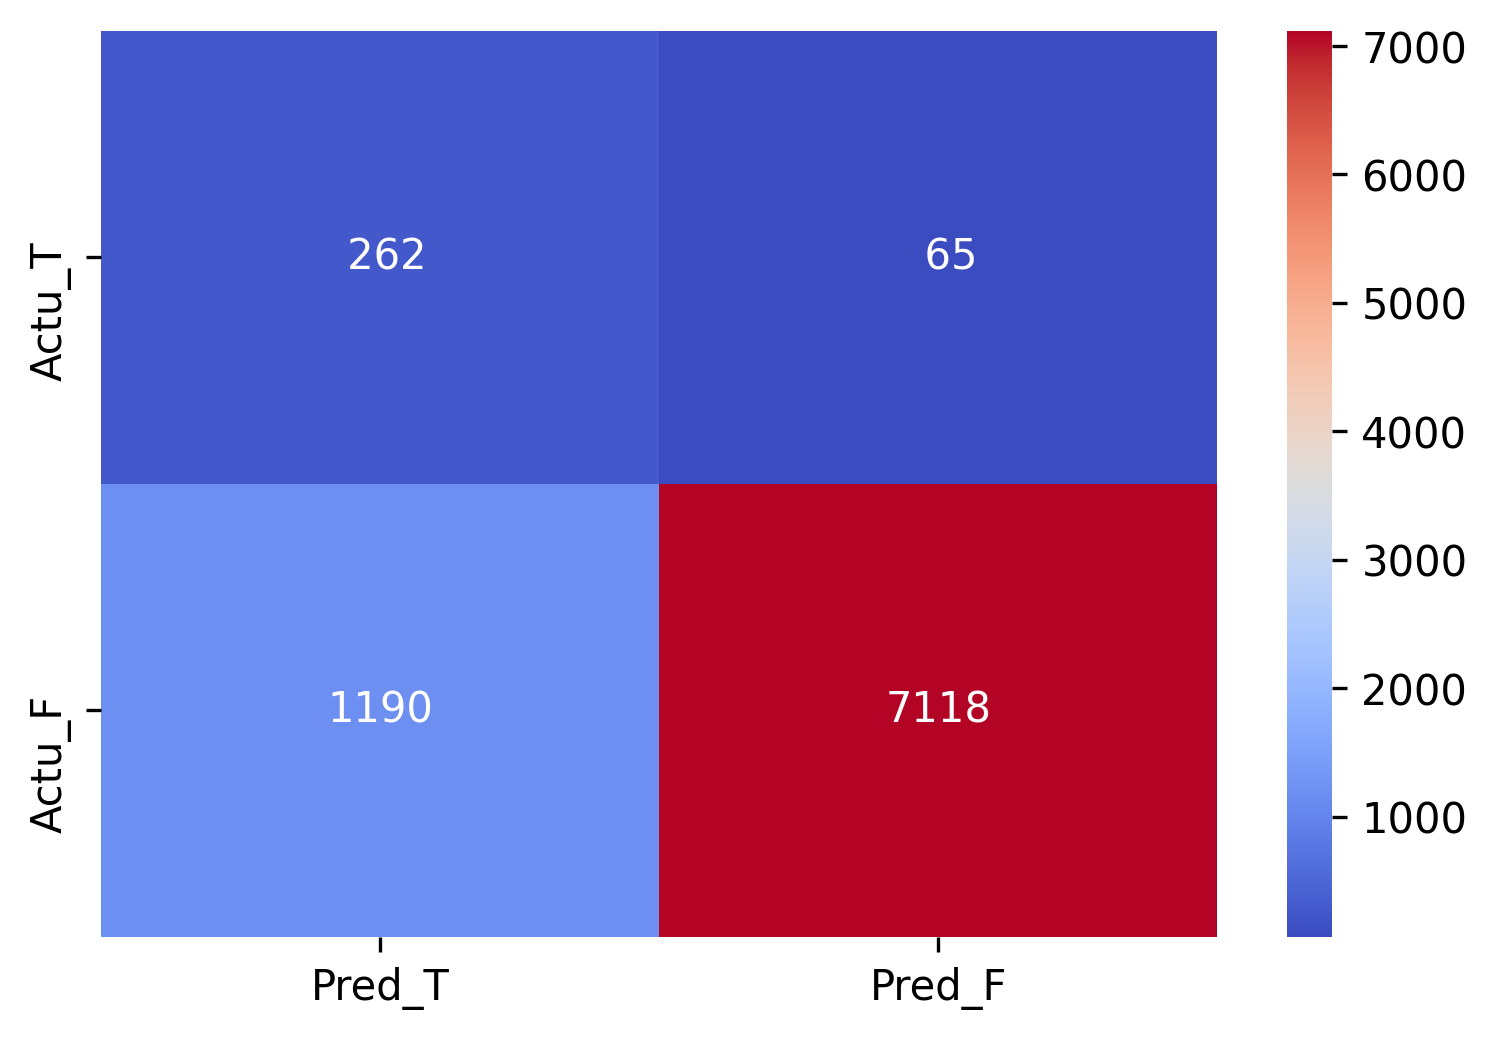

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
y_pred=svm.predict(X_test)
plt.figure(dpi=300)
sns.heatmap(confusion_matrix(y_test,y_pred),fmt='4d',xticklabels=['Pred_T','Pred_F'], yticklabels=['Actu_T','Actu_F'], cmap="coolwarm",annot=True)

In [24]:
confusion_matrix(y_test,y_pred)

array([[ 262,   65],
       [1190, 7118]], dtype=int64)

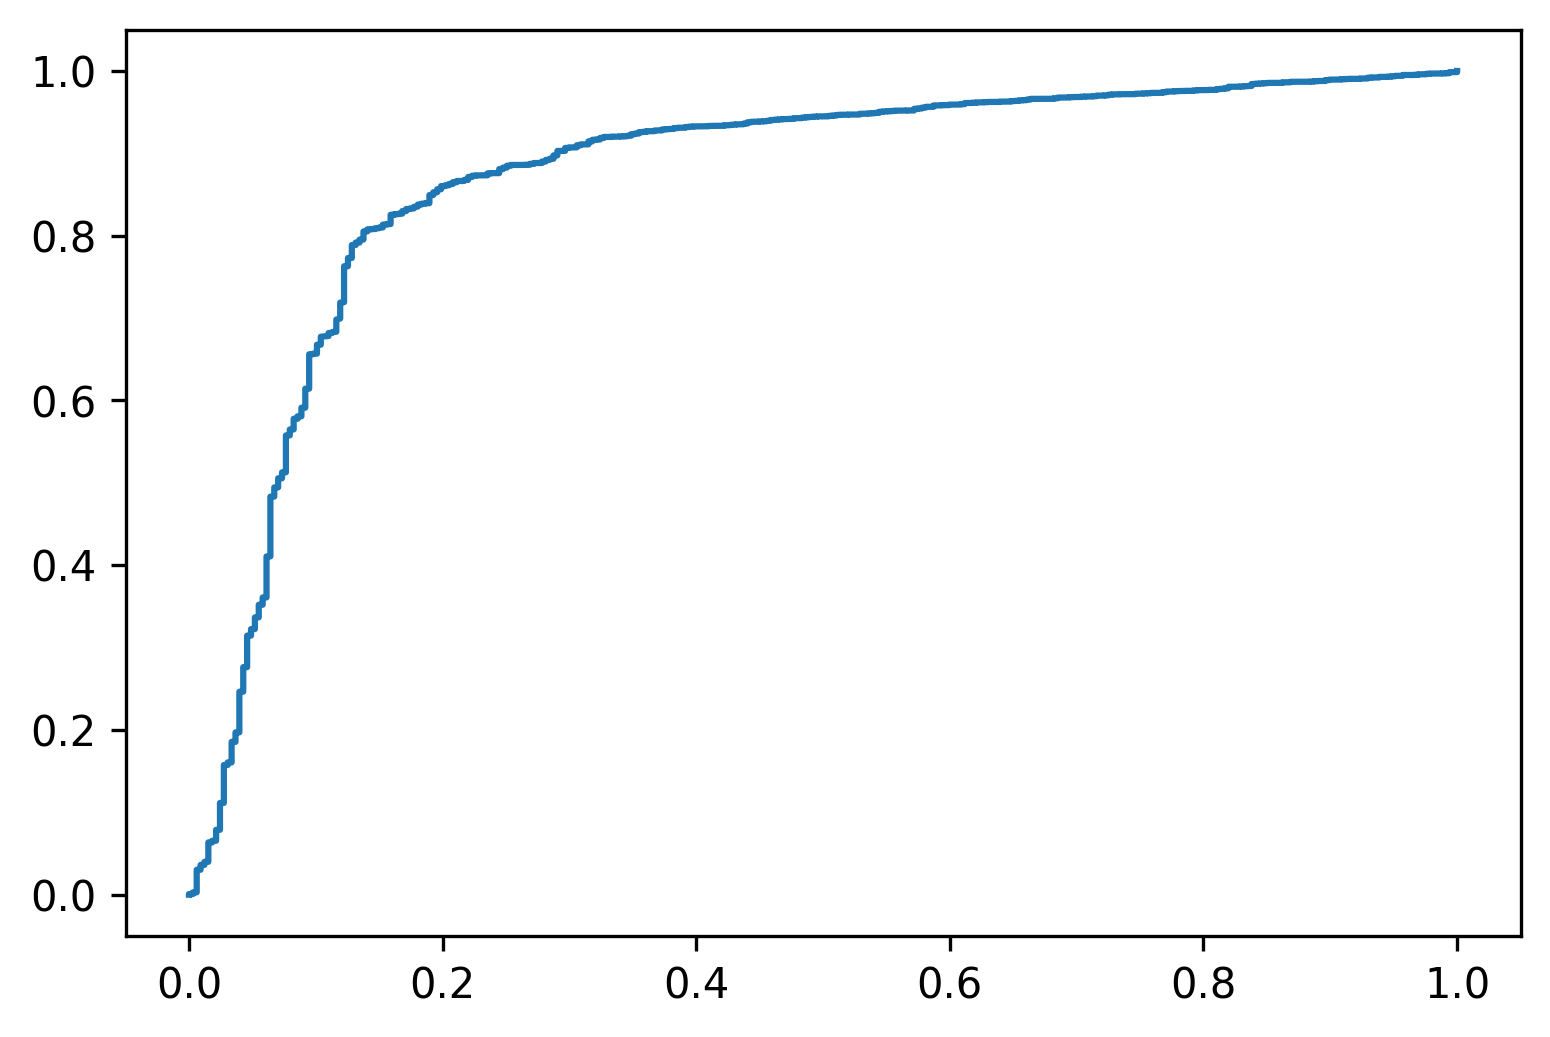

In [26]:
# roc
from sklearn.metrics import roc_curve
y_pred_prob=svm.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test,y_pred_prob[:,1])
plt.figure(dpi=300)
plt.plot(fpr,tpr)

### 分类正确率这么高的吗...

*主题向量化*与*处理样本不平衡*这两步已经解决
主要困难是：
1. 运行效率太低,跑一次40min左右


    我在想，或许可以将svm作为一种主题聚类baseline的方法，然后不用主题聚类，比如用贝叶斯等，作出一个分类模型，两者对比。突出主题聚类（Bertopic）的优越性。
2. 主题283个，是否有些过多？


   一共跑出来283个主题，我将这些主题全部都作为特征了。在运算时还好大概是(40000,283)左右的矩阵作为数据集。后续是否还需要作一些特征工程？比如主题的二次聚类？特征数精简一些？
    现在基于berttopic的使用svm进行测试，正确率已经达到了85%左右。可以将这个数值作为一个baseline，看看后续的方法能否提升正确率。
3. 下一步可以输出svm的参数权重，看看主题的重要性


   但有些主题的可解释性太低了，这也是一个问题（比如，有些主题内的词差很大，暂时还没找到例子）